<p> Code found <a href="https://www.youtube.com/watch?v=M2PqI2JD2jo&feature=youtu.be">on the internet</a>.</p>

In [2]:
from numpy import *
from numpy.linalg import *
import matplotlib.pyplot as plt
from matplotlib import cm
from numba import jit
import time as time

In [3]:
from mpl_toolkits import axes_grid1

#https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [4]:
maxIter = 200000 # Total number of time iterations.
Re      = 25.0  # Reynolds number.

finegrain = 4.00

nx = int(1024*finegrain)
ny = int(1024/2*finegrain)
ly=ny-1.0
q = 9 # Lattice dimensions and populations.


cx = nx/4
cy=ny/2
r=7*ny/9/2          # Coordinates of the cylinder.

uLB     = 0.04                       # Velocity in lattice units.
nulb    = uLB*r/Re; omega = 1.0 / (3.*nulb+0.5); # Relaxation parameter.


In [5]:
c = array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) # Lattice velocities.
t = 1./36. * ones(q)                                   # Lattice weights.
t[asarray([norm(ci)<1.1 for ci in c])] = 1./9.; t[0] = 4./9.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 
i1 = arange(q)[asarray([ci[0]<0  for ci in c])] # Unknown on right wall.
i2 = arange(q)[asarray([ci[0]==0 for ci in c])] # Vertical middle.
i3 = arange(q)[asarray([ci[0]>0  for ci in c])] # Unknown on left wall.


In [6]:
sumpop = lambda fin: sum(fin,axis=0) # Helper function for density computation.
@jit(parallel=True)
def equilibrium(rho,u):              # Equilibrium distribution function.
    cu   = 3.0 * dot(c,u.transpose(1,0,2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = zeros((q,nx,ny))
    for i in range(q): feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

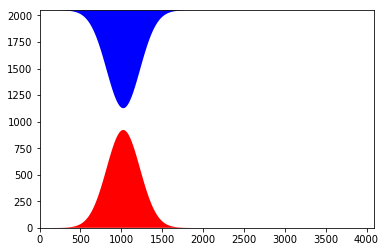

In [7]:

gaussian = lambda x, amp, mu, sigma:amp* ny * exp( -(x-mu)**2 / (2*sigma**2))

x = linspace(0, nx, 1000)
y = gaussian(x, 0.45, nx/4, nx/20)
y2 = ny-gaussian(x, 0.45, nx/4, nx/20)

plt.fill(x, y, 'r-', x, y2, 'b-')
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.show()
plt.close()



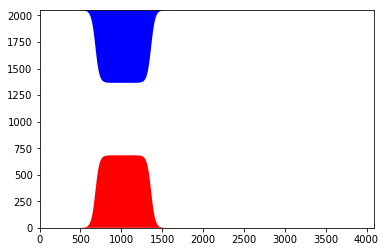

In [19]:
def tanh_constriction(x, amp, centre, length, sharpness):
    ret = zeros(x.shape)
    ret[x >= centre] = 0.5*amp* ny*(tanh(sharpness*(centre - x[x >= centre] +length/2)) + 1)
    ret[x < centre] = 0.5*amp* ny*(tanh(sharpness*(x[x < centre] + length/2  - centre)) + 1)
    return ret

x = linspace(0, nx, 1000)
y = tanh_constriction(x, 0.3333, nx/4, nx/6,  0.02)
y2 = ny-tanh_constriction(x, 0.3333, nx/4, nx/6, 0.02)

plt.fill(x, y, 'r-', x, y2, 'b-')
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.show()
plt.close()

In [7]:
obstacle_one = fromfunction(lambda x,y: gaussian(x, 0.45, nx/4, nx/20) > y, (nx,ny))
obstacle_two = fromfunction(lambda x,y: ny-gaussian(x, 0.45, nx/4, nx/20) < y, (nx,ny))

obstacle = obstacle_one + obstacle_two


obstacle_one_tanh = fromfunction(lambda x,y: tanh_constriction(x, 0.35, nx/4, nx/6, 0.02) > y, (nx,ny))
obstacle_two_tanh = fromfunction(lambda x,y: ny-tanh_constriction(x, 0.35, nx/4,nx/6, 0.02) < y, (nx,ny))
obstacle_tanh= obstacle_one_tanh+ obstacle_two_tanh

vel = fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*sin(y/ly*2*pi)),(2,nx,ny))
feq = equilibrium(1.0,vel)
fin = feq.copy()


In [20]:
start_time = time.time ()
report_time = start_time

for j in range(maxIter): 
    fin[i1,-1,:] = fin[i1,-2,:] # Right wall: outflow condition.
    rho = sumpop(fin)           # Calculate macroscopic density and velocity.
    u = dot(c.transpose(), fin.transpose((1,0,2)))/rho

    u[:,0,:] =vel[:,0,:] # Left wall: compute density from known populations.
    rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))

    feq = equilibrium(rho,u) # Left wall: Zou/He boundary condition.
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]
    fout = fin - omega * (fin - feq)  # Collision step.
    for i in range(q):
        fout[i,obstacle] = fin[noslip[i],obstacle]
        fout[i,obstacle_tanh] = fin[noslip[i],obstacle_tanh]

    for i in range(q): # Streaming step.
        fin[i,:,:] = roll(roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)
 
    elapsed_time = time.time() - report_time
    
    if elapsed_time > 10:
        print ("Iteration %d, time spent %.3f (total %.3f)" % (j, elapsed_time, time.time() - start_time))
        report_time = time.time()
        
    if (j%100==0): # Visualization
        print ("Iteration %d, time spent %.3f" % (j, time.time() - start_time))
        plt.clf()
        plt.figure(dpi=1200)
        im = plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.winter)
        plt.title("Iteration %d, Re=%d" % (j, Re))
        add_colorbar(im)
        plt.savefig("palabos/constriction_two_sides_finegrain%diteration%dre%d.png" % (finegrain*100, j, Re))
#         plt.savefig("palabos/constriction_tanh_two_sides_finegrain%diteration%dre%d.png" % (finegrain*100, j, Re))

        plt.close()  


NameError: name 'fin' is not defined